In [1]:
import os
import json
from torch import load, save
from numpy import sort
from random import shuffle
from PIL import Image
from matplotlib import pylab as pl
%matplotlib inline

In [2]:
# Set user-defined parameters

inatpath = '/data/inat/'            # The location of your downloaded 'train_val_images' folder. Make sure it ends in '/'!
annopath = '/data/inat/'            # The location of your downloaded 'train_2017_bboxes.json' file. Make sure it ends in '/'!
datapath = '/data/pm484/'            # Wherever you want your new dataset to appear. Make sure it ends in '/'!
catsize_min = 50           # The smallest category allowed in our data set
catsize_max = 1000         # The largest category allowed in our data set
random_assign = False      # Split categories randomly over the representation and evaluation sets, 
                           # or use the splits from the paper?
if not random_assign:
    assert catsize_min==50 and catsize_max==1000, 'The provided splits work only for category sizes between 50 and 1000.'

In [3]:
# Compile bounding box annotations for each image id

with open(annopath+'train_2017_bboxes.json') as f:
    allinfo = json.load(f)
annolist = allinfo['annotations']

annodict = dict() # im_id to list of box_ids
boxdict = dict() # box_id to box coords
catdict = dict() # dict of numerical category codes / labels to corresponding list of image ids
for d in annolist:
    im = d['image_id']
    boxid = d['id']
    cat = d['category_id']
    
    # Add box_id to image entry
    if im in annodict:
        annodict[im].append(boxid)
    else:
        annodict[im] = [boxid]
        
    # Add mapping from box_id to box
    boxdict[boxid] = d['bbox']
    
    # Add image to category set
    if cat in catdict:
        catdict[cat].add(im)
    else:
        catdict[cat] = set([im])
    
print("Built annotation dictionaries")

Built annotation dictionaries


In [4]:
# assemble im_id -> filepath dictionary
namelist = allinfo['images']
keys = []
vals = []
for d in namelist:
    keys.append(d['id'])
    vals.append(inatpath+d['file_name'])
pather = dict(zip(keys,vals))

print("Built path dictionary")

Built path dictionary


Detected 1135 categories of the desired size


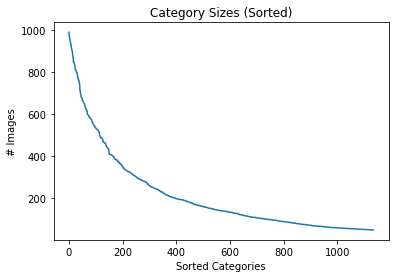

In [5]:
# Visualize the categories that meet the given size requirements

catsizes = sort([(len(catdict[c])) for c in catdict if len(catdict[c]) >= catsize_min and len(catdict[c]) <= catsize_max])
print('Detected %d categories of the desired size' % len(catsizes))
pl.figure()
pl.plot(catsizes[::-1])
pl.title('Category Sizes (Sorted)')
pl.ylabel('# Images')
pl.xlabel('Sorted Categories')
pl.show()

In [6]:
# Pare down the category dictionary to the desired size

print('Initial size: %d categories' % len(list(catdict.keys())))
clist = list(catdict.keys())
for c in clist:
    if len(catdict[c]) < catsize_min or len(catdict[c]) > catsize_max:
        catdict.pop(c)
print('Final size: %d categories' % len(list(catdict.keys())))

supercat = dict()
for d in allinfo['categories']:
    catid = d['id']
    if catid in catdict:
        sc = d['supercategory']
        if sc in supercat:
            supercat[sc].append(catid)
        else:
            supercat[sc] = [catid,]
print('\nSupercategory distributions:')
for sc in supercat:
    print(sc+':', len(supercat[sc]))

Initial size: 2854 categories
Final size: 1135 categories

Supercategory distributions:
Insecta: 332
Animalia: 22
Aves: 478
Reptilia: 124
Amphibia: 50
Mammalia: 67
Actinopterygii: 7
Arachnida: 22
Mollusca: 33


In [7]:
# Create category splits

if random_assign:
    catlist = list(catdict.keys())
    shuffle(catlist)
    testlen = len(catlist)//5
    testcatlist = catlist[:testlen]
    traincatlist = catlist[testlen:]
else:
    traincatlist = load('helpful_files/traincatlist.pth')
    testcatlist = load('helpful_files/testcatlist.pth')

print('Category splits assigned. \nRepresentation set has %d of %d concepts, evaluation has %d.' 
      % (len(traincatlist), len(list(catdict.keys())), len(testcatlist)))

Category splits assigned. 
Representation set has 908 of 1135 concepts, evaluation has 227.


In [8]:
# Build representation set

boxdict_smaller = dict()
count = 0
catlist = traincatlist
print("Categories completed:")
for c in catlist:
    # For each category:
    if not os.path.exists(datapath+'train/'+str(c)):
        os.makedirs(datapath+'train/'+str(c))
    ims = catdict[c]
    for imkey in ims:
        # For each image:
        path = pather[imkey]
        newpath = datapath+'train/'+str(c)+'/'+path[path.rfind('/')+1:-4]+'.bmp'
        # Downsize the image to 84x84
        with open(path, 'rb') as f:
            p = Image.open(f)
            w,h = p.size
            p = p.convert('RGB')
        p = p.resize((84, 84), Image.BILINEAR)
        p.save(newpath)
        # Downsize the bounding box annotations to 10x10
        boxes = annodict[imkey]
        boxdict_smaller[newpath] = []
        for boxcode in boxes:
            box = boxdict[boxcode]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            boxdict_smaller[newpath].append([xmin*10/w, ymin*10/h, xmax*10/w, ymax*10/h])
    count += 1
    if count%50 == 0:
        print(count)

print("Representation set complete!")

Categories completed:
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
Representation set complete!


In [9]:
# Build evaluation set

count = 0
catlist = testcatlist
print("Categories completed:")
for c in catlist:
    # For each category:
    if not os.path.exists(datapath+'test/'+str(c)):
        os.makedirs(datapath+'test/'+str(c))
    ims = catdict[c]
    for imkey in ims:
        # For each image:
        path = pather[imkey]
        newpath = datapath+'test/'+str(c)+'/'+path[path.rfind('/')+1:-4]+'.bmp'
        # Downsize the image to 84x84
        with open(path, 'rb') as f:
            p = Image.open(f)
            w,h = p.size
            p = p.convert('RGB')
        p = p.resize((84, 84), Image.BILINEAR)
        p.save(newpath)
        # Downsize the bounding box annotations to 10x10
        boxes = annodict[imkey]
        boxdict_smaller[newpath] = []
        for boxcode in boxes:
            box = boxdict[boxcode]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            boxdict_smaller[newpath].append([xmin*10/w, ymin*10/h, xmax*10/w, ymax*10/h])
    count += 1
    if count%50 == 0:
        print(count)

print("Evaluation set complete!")

Categories completed:
50
100
150
200
Evaluation set complete!


In [10]:
# Compile reference images within the evaluation set

count = 0
catlist = testcatlist
print("Categories completed:")
for c in catlist:
    # For each category:
    if not os.path.exists(datapath+'repr/'+str(c)):
        os.makedirs(datapath+'repr/'+str(c))
    ims = list(catdict[c])
    ims = ims[:len(ims)//5]
    for imkey in ims:
        # For each image:
        path = pather[imkey]
        oldpath = datapath+'test/'+str(c)+'/'+path[path.rfind('/')+1:-4]+'.bmp'
        newpath = datapath+'repr/'+str(c)+'/'+path[path.rfind('/')+1:-4]+'.bmp'
        # Create a softlink to the corresponding evaluation set image
        os.symlink(oldpath, newpath)
        # Copy over the bounding box annodations from the softlinked image
        boxdict_smaller[newpath] = boxdict_smaller[oldpath]
    count += 1
    if count%50 == 0:
        print(count)
        
print("Reference images compiled!")

Categories completed:
50
100
150
200
Reference images compiled!


In [11]:
# Compile query images within the evaluation set

count = 0
catlist = testcatlist
print("Categories completed:")
for c in catlist:
    # For each category:
    if not os.path.exists(datapath+'query/'+str(c)):
        os.makedirs(datapath+'query/'+str(c))
    ims = list(catdict[c])
    ims = ims[len(ims)//5:]
    for imkey in ims:
        # For each image:
        path = pather[imkey]
        oldpath = datapath+'test/'+str(c)+'/'+path[path.rfind('/')+1:-4]+'.bmp'
        newpath = datapath+'query/'+str(c)+'/'+path[path.rfind('/')+1:-4]+'.bmp'
        # Create a softlink to the corresponding evaluation set image
        os.symlink(oldpath, newpath)
        # Copy over the bounding box annodations from the softlinked image
        boxdict_smaller[newpath] = boxdict_smaller[oldpath]
    count += 1
    if count%50 == 0:
        print(count)
save(boxdict_smaller, 'helpful_files/box_coords.pth')
        
print("Query images compiled!")

Categories completed:
50
100
150
200
Query images compiled!


In [12]:
# Use a recursive md5 checksum to verify that the constructed dataset reproduces the original

# NOTE: this code only checks the assignments of photos to categories. 
# Thus, changing any file or folder names WILL cause the check to fail, even if the images themselves are still correct.

import hashlib

# Get hashes of relative locations for each photo in the dataset
hashlist = []
subdirs = ['train/', 'test/', 'repr/', 'query/']
for subdir in subdirs:
    for cat in os.listdir(datapath+subdir):
        hashlist = hashlist + [hashlib.md5((subdir+cat+'/'+file).encode()).hexdigest() 
                               for file in os.listdir(datapath+subdir+cat)]
# Get a hash for the sorted list of hashes
hashlist.sort()
md5 = hashlib.md5("".join(hashlist).encode()).hexdigest()
# Compare
print("Your md5 hash is:", md5)
print()
if not random_assign:
    if md5!="e11fce3d5ab8929a92ae2dd25a83b2ad":
        print("ALERT: Something went wrong. Your dataset does not match the original.")
    else:
        print("Congratulations! Your dataset appears to be a faithful reproduction.")

Your md5 hash is: e11fce3d5ab8929a92ae2dd25a83b2ad

Congratulations! Your dataset appears to be a faithful reproduction.


In [ ]:
# Shut down the notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

In [ ]:
#                           CONCLUDES DOWNSCALED VERSION OF META_INAT DATASET